# Data Preparation

This program contains two sections that prepares:
- Training Data
- SPX Data (Test Data)

In [23]:
# This code will connect the Colab program to the Google Drive folder
# It will create a pop-up window where access has to be granted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import math
import random
from sklearn import preprocessing
from datetime import timedelta
import seaborn as sns

# Set the path for the data folder
data_path = "/content/drive/My Drive/Timeseries_Transformer/Data" ########### This line should be changed ###########

## Training data

This section retrieves the raw training data, process it and saves a final dataframe which is ready to read into the Transformer model

In [ ]:
#### Retrieveing Data ####

# The data is stored in folders by years, month and day, and we use this to create the date for the data when reading it in

# Creates an overall dataframe to collect the data
df = pd.DataFrame()

# Loops over every year folder
for year in os.listdir(f"{data_path}/Train Data"):

    # We only want training data prior to 2018
    if int(year) < 2018:

      # Loops over every month folder
      for month in os.listdir(f"{data_path}/Train Data/{year}"):

          # Loops over every day folder
          for day in os.listdir(f"{data_path}/Train Data/{year}/{month}"):

              # Only creates a day dataframe and appends it to the main dataframe if there are files in the day folder
              if len(os.listdir(f"{data_path}/Train Data/{year}/{month}/{day}")) > 0:

                  # Creating the day dataframe
                  df_day = pd.DataFrame()

                  # Loops over every file in the day folder
                  for file in os.listdir(f"{data_path}/Train Data/{year}/{month}/{day}"):

                      # Creates a temporary dataframe for the file in the loop
                      df_temp = pd.read_excel(f"{data_path}/Train Data/{year}/{month}/{day}/{file}").drop(index=[0,1], axis=0)
                      df_temp.index = df_temp['Ticker']
                      df_temp = df_temp.drop(['Ticker', 'Name'], axis= 1)

                      # Concatenates the temporary dataframe to the daily dataframe
                      df_day = pd.concat([df_day, df_temp], axis=1, join='outer')

                  # Removes column dublicates (some of the columns/fields are in multiple files)
                  df_day = df_day.T.drop_duplicates().T

                  # Stores the date as a variable in the dataframe
                  df_day['Date'] = f'{day}-{month}-{year}'

                  df_day = df_day.reset_index()
                  df_day = df_day.loc[:, ~df_day.columns.duplicated()] # Dropping duplicated columns
                  df = df.reset_index(drop=True)

                  # Appends the daily data to the overall dataframe
                  df = pd.concat([df, df_day], axis=0)

# Displays the overall training dataframe
df

,Ticker,Price:D-1,1W Tot Ret,1W Volat,1M Volat,Market Cap:D-1,Date
0,AFC PZ Equity,1360500.0,0.0,0,0.1327,846230976.0,02-01-2012
1,BRK/A US Equity,114755.0,-1.5232,9.861,16.5659,189218193408.0,02-01-2012
2,MAERSKB DC Equity,38500.0,4.6196,14.2531,27.7944,162109718528.0,02-01-2012
3,LISN SW Equity,31390.0,1.7504,12.577,11.1819,6942448640.0,02-01-2012
4,RLD SW Equity,24000.0,-0.6211,17.8674,20.2831,2160000000.0,02-01-2012
...,...,...,...,...,...,...,...
2615,SON PL Equity,1.138,-2.6518,20.0329,27.8184,2276000000.0,25-12-2017
2616,TIT IM Equity,0.738,0.4765,15.1857,26.3302,14854663168.0,25-12-2017
2617,O5G GR Equity,0.665,0.3017,8.4008,18.9765,6310000640.0,25-12-2017
2618,ETE GA Equity,0.316,2.9316,20.7563,47.3494,2890499840.0,25-12-2017


In [ ]:
# Check to see if returns for all weeks are included

date = pd.to_datetime('2012-01-02')
count=0

while date <= pd.to_datetime('2018-01-01'):

    test = date not in df['Date']
    count += 1

    if test == False:
        print(f"Returns for {date} are missing")
        break

    date = date + timedelta(weeks=1)

print(f'Check! All weeks are included, {count}')

Check! All weeks are included, 314


In [ ]:
# Saves the raw
df.to_csv(f"{data_path}/Train_raw.csv", index=False)

In [ ]:
variable = '1W Tot Ret'

# Creates a list with Ticker, Date and the chosen variable
col = ['Ticker', 'Date', variable]

# Subsets the overall data and widens it
df_return = df[col].pivot(index='Date', columns='Ticker', values=variable).reset_index()

# Sort by date
df_return['Date'] = pd.to_datetime(df_return['Date'], format= '%d-%m-%Y')
df_return = df_return.sort_values('Date')

# Steps to clean the data. NaN and empty values is getting filled with 0 (Later sequences with too many consecutive 0's will be removed)
#df_return = df_return.fillna(0) # Is performed in the next code section
df_return = df_return.replace(' ', 0)

# Sets the index as the Date variable and drops the variable
df_return.index = df_return['Date']
df_return = df_return.drop(columns='Date')

# Performing the log transformation
df_return = np.log( 1 + df_return / 100)

# Reset index and displays the dataframe
df_return = df_return.reindex(sorted(df_return.columns), axis=1)
df_return = df_return.reset_index()
df_return

Ticker,Date,0357149D US Equity,0609237D CN Equity,0616503D SS Equity,0625767D US Equity,0838256D US Equity,0848680D US Equity,0867887D US Equity,0876711D LN Equity,0878522D US Equity,...,ZOT SM Equity,ZPG LN Equity,ZSIL SW Equity,ZSP CN Equity,ZSPH US Equity,ZTS US Equity,ZU US Equity,ZUGER SW Equity,ZURN SW Equity,ZVOI US Equity
0,2012-01-02,-0.007139,-0.003353,0.043302,NaN,NaN,0.012903,0.001031,-0.003231,-0.005029,...,0.004742,NaN,-0.036280,NaN,NaN,NaN,NaN,0.003976,0.011835,NaN
1,2012-01-09,0.006809,0.006218,-0.004965,NaN,NaN,-0.061694,-0.015585,0.053556,0.004715,...,0.019673,NaN,0.035881,NaN,NaN,NaN,NaN,-0.006968,-0.001413,NaN
2,2012-01-16,0.030963,0.008545,0.063744,NaN,NaN,0.048790,0.006524,-0.015456,-0.059763,...,0.000000,NaN,0.036228,NaN,NaN,NaN,NaN,0.018803,0.040633,0.083689
3,2012-01-23,-0.008218,-0.009261,0.052071,NaN,0.128371,-0.026317,0.005447,-0.022845,NaN,...,-0.010256,NaN,0.055240,NaN,NaN,NaN,NaN,-0.009852,0.038612,NaN
4,2012-01-30,0.016845,0.006657,-0.012891,NaN,NaN,-0.040822,0.005417,NaN,NaN,...,-0.009416,NaN,0.019193,NaN,NaN,NaN,NaN,-0.005959,-0.033196,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2017-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009693,NaN,NaN,0.004107,NaN,0.008282,NaN,NaN,-0.018591,NaN
309,2017-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.008537,NaN,NaN,0.010464,NaN,-0.007296,NaN,NaN,0.015908,NaN
310,2017-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005328,NaN,NaN,0.019943,NaN,0.010505,NaN,NaN,-0.004712,NaN
311,2017-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006431,NaN,NaN,0.012642,NaN,0.011912,NaN,NaN,0.024989,NaN


In [ ]:
## Now we create the sequence dataframe, which is going to be used in the model

# Setting the time series length
time_length = 52

# Setting the number of observations in a month (the number of observations it jumps):
month = 4

# Setting the number of clearence observations
clearing = 0

# Makes sure the data is sorted correctly
df_return = df_return.sort_values(by='Date')

# Creating the main DataFrame
df_data = pd.DataFrame([])

# Amount of iterations
iterator = math.floor( (len(df_return) - time_length) / (month + clearing)) + 1

# Loop over different periods
for i in range(0, iterator):

  # This variable makes sure to jump 4 observations for every iteration
  d = i * month

  # Creating a temperary dataframe for the 'Time_length' period
  temp_df = df_return.iloc[d : d + time_length, :].reset_index(drop=True)

  # Drops columns with NaN
  temp_df = temp_df.dropna(axis=1)

  # # Dropping columns (Tickers) with more than 5 consecutive zeros
  thresh = 5
  to_drop = temp_df.eq(0).rolling(thresh).sum().eq(thresh).any()
  temp_df = temp_df.loc[:, ~to_drop]

  # Saves the Date of the first day in the period
  date_start = temp_df['Date'][0]

  # Drop the current 'Date' variable
  temp_df = temp_df.drop(columns='Date')

  # Calculate the 4-week target log-return
  target = temp_df.iloc[- month:, :].sum()

  # Standardize
  min = temp_df.iloc[:time_length - month, :].min() # Normal
  max = temp_df.iloc[:time_length - month, :].max() # Normal
  # min = temp_df.iloc[:time_length - month, :].values.min() # All
  # max = temp_df.iloc[:time_length - month, :].values.max() # All
  std = temp_df.iloc[:time_length - month, :].std()
  mn = temp_df.iloc[:time_length - month, :].mean()

  #temp_df = ( (temp_df - min) /  (max - min) ) - 0.5
  temp_df = (temp_df-mn) /std
  target = (target-mn) /std

  zero = (0 - mn) /std

  # Transpose dataframe
  temp_df = temp_df.T

  # Inserting variables we want to save
  temp_df.insert(0, 'Std', std)
  temp_df.insert(1, 'Mean', mn)
  temp_df.insert(2, 'Target', target)

  # Insert the first day in the period as the date
  temp_df.insert(0, 'Start', pd.to_datetime(date_start) - timedelta(weeks= 1))
  temp_df.insert(1, 'End', pd.to_datetime(date_start) + timedelta(weeks=time_length -1))

  # Concatenate the temporary data and the main dataframe
  df_data = pd.concat([df_data, temp_df], axis=0)

# Sort data by date and display it
df_data = df_data.sort_values(by='Start')
df_data

,Start,End,Std,Mean,Target,0,1,2,3,4,...,42,43,44,45,46,47,48,49,50,51
Ticker,,,,,,,,,,,,,,,,,,,,,
0848680D US Equity,2011-12-26,2012-12-24,0.070169,0.018523,-0.571562,-0.080081,-1.143180,0.431351,-0.639025,-0.845735,...,-0.289046,-0.748845,0.395460,-0.615254,-0.417208,-0.085343,-0.012613,-0.414256,-0.518012,-0.418591
ON US Equity,2011-12-26,2012-12-24,0.045480,-0.004158,2.034040,0.435876,1.908284,-0.641805,2.036218,-0.057987,...,0.164235,0.451889,1.172715,-0.811848,-0.887582,1.158916,1.444163,0.584085,0.763100,-0.483041
OMV AV Equity,2011-12-26,2012-12-24,0.035286,0.003772,0.209700,0.189606,-0.059739,-0.307844,1.355347,0.190111,...,-0.379288,-0.846366,1.199650,-1.522898,-0.122562,-0.070323,0.049260,0.177152,-0.256289,-0.081080
OML LN Equity,2011-12-26,2012-12-24,0.026060,0.005241,2.246997,-0.144441,0.277326,1.226403,1.460132,-0.878015,...,1.055692,-1.223971,0.045677,-0.923465,0.386810,-0.766281,0.520807,0.419635,-0.157164,0.860373
OMI US Equity,2011-12-26,2012-12-24,0.022801,0.000982,-0.559379,-0.576399,-0.359849,0.541192,2.323201,1.231194,...,-0.821738,0.401402,0.169911,0.032740,-0.149242,-0.119050,-2.563318,0.818454,0.943932,0.112350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EXEL US Equity,2016-12-19,2017-12-18,0.064486,0.009458,0.105186,-1.007860,-0.658160,2.407820,0.652714,-0.332077,...,1.761518,-1.276974,-0.672783,0.607669,-0.918858,-0.386630,0.288501,0.537541,-0.807384,-0.353482
EXP US Equity,2016-12-19,2017-12-18,0.024582,0.001305,2.050313,-0.049513,-0.423011,0.144621,0.679837,0.071808,...,0.321916,-0.270173,-0.937015,-0.941007,0.189209,0.384867,-0.389854,3.224025,0.495431,-1.438569
EXPD US Equity,2016-12-19,2017-12-18,0.019928,0.001883,4.982290,-0.753607,-0.790787,-0.018738,0.684680,-1.761303,...,-1.040213,0.177536,-0.622907,-1.028403,1.553974,-0.365500,0.881032,3.983572,-0.693140,0.527320


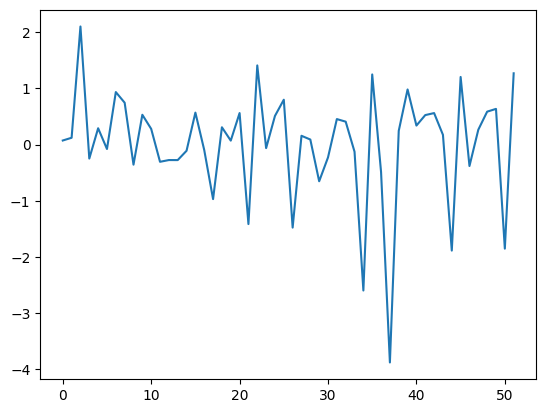

In [ ]:
# Plots a random sequence
periods = np.arange(len(df_data))
plt.plot(df_data.iloc[random.choice(periods), 5:])

In [ ]:
# Saves the Data
df_data.reset_index(names='Ticker').to_csv(f"{data_path}/Train_data.csv", index=False)

## SPX data

This section retrieves the raw SPX data, process it and saves a final dataframe which is ready to use for testing the model

In [ ]:
# The data is stored in folders by years, month and day, and we use this to create the date for the data when reading it in

# Creates an overall dataframe to collect the data
df = pd.DataFrame()

# Loops over every year folder
for year in os.listdir(f"{data_path}/SPX Data"):

    # Loops over every month folder
    for month in os.listdir(f"{data_path}/SPX Data/{year}"):

        # Loops over every day folder
        for day in os.listdir(f"{data_path}/SPX Data/{year}/{month}"):

            # Only creates a day dataframe and appends it to the main dataframe if there are files in the day folder
            if len(os.listdir(f"{data_path}/SPX Data/{year}/{month}/{day}")) > 0:

                # Creating the day dataframe
                df_day = pd.DataFrame()

                # Loops over every file in the day folder
                for file in os.listdir(f"{data_path}/SPX Data/{year}/{month}/{day}"):

                    # Creates a temporary dataframe for the file in the loop
                    df_temp = pd.read_excel(f"{data_path}/SPX Data/{year}/{month}/{day}/{file}").drop(index=[0,1], axis=0)
                    df_temp.index = df_temp['Ticker']
                    df_temp = df_temp.drop(['Ticker', 'Name'], axis= 1)

                    # Concatenates the temporary dataframe to the daily dataframe
                    df_day = pd.concat([df_day, df_temp], axis=1, join='outer')

                # Removes column dublicates (some of the columns/fields are in multiple files)
                df_day = df_day.T.drop_duplicates().T

                # Stores the date as a variable in the dataframe
                df_day['Date'] = f'{day}-{month}-{year}'

                df_day = df_day.reset_index()
                df_day = df_day.loc[:, ~df_day.columns.duplicated()] # Dropping duplicated columns
                df = df.reset_index(drop=True)

                # Appends the daily data to the overall dataframe
                df = pd.concat([df, df_day], axis=0)

df['Date'] =  pd.to_datetime(df['Date'], format= '%d-%m-%Y')
df

,Ticker,Price:D-1,1W Tot Ret,1W Volat,1M Volat,Date
0,NVR US Equity,5327.2202,0.7575,39.8755,36.6412,2022-01-31
1,AMZN US Equity,2991.47,3.4796,46.2436,38.6596,2022-01-31
2,GOOG US Equity,2713.97,4.0856,37.8345,30.9257,2022-01-31
3,GOOGL US Equity,2706.0701,3.4399,38.7974,30.4148,2022-01-31
4,BKNG US Equity,2456.1299,4.5331,23.3149,27.8184,2022-01-31
...,...,...,...,...,...,...
500,F US Equity,12.63,4.294,19.1428,14.822,2017-12-04
501,UA US Equity,11.98,5.5507,50.923,47.0481,2017-12-04
502,AES US Equity,10.77,0.2793,16.8295,25.648,2017-12-04
503,AMD US Equity,10.03,-13.1602,43.4506,46.8152,2017-12-04


In [ ]:
# Saves the raw SPX data to create portfolio returns later on
df.to_csv(f"{data_path}/SPX_raw.csv", index=False)

In [ ]:
# Check to see if returns for all weeks are included

date = pd.to_datetime('2017-01-02')

while date <= pd.to_datetime('2023-12-11'):

    test = date not in df['Date']

    if test == False:
        print(f"Returns for {date} are missing")
        break

    date = date + timedelta(weeks=1)

print('Check! All weeks are included')

Check! All weeks are included


In [ ]:
variable = '1W Tot Ret'

# Creates a list with Ticker, Date and the chosen variable
col = ['Ticker', 'Date', variable]

# Subsets the overall data and widens it
df_return = df[col].pivot(index='Date', columns='Ticker', values=variable).reset_index()

# Sort by date
df_return['Date'] = pd.to_datetime(df_return['Date'], format= '%d-%m-%Y')
df_return = df_return.sort_values('Date')

# Steps to clean the data. NaN and empty values is getting filled with 0 (Later sequences with too many consecutive 0's will be removed)
#df_return = df_return.fillna(0) # Is performed in the next code section
df_return = df_return.replace(' ', 0)

# Sets the index as the Date variable and drops the variable
df_return.index = df_return['Date']
df_return = df_return.drop(columns='Date')

# Performing the log transformation
df_return = np.log( 1 + df_return / 100)

# Reset index and displays the dataframe
df_return = df_return.reindex(sorted(df_return.columns), axis=1)
df_return = df_return.reset_index()
df_return

Ticker,Date,1518855D US Equity,1539941D US Equity,1697067D US Equity,1715651D US Equity,1806854D US Equity,1831877D US Equity,1856613D US Equity,1922150D US Equity,1927294D US Equity,...,XLNX US Equity,XOM US Equity,XRAY US Equity,XRX US Equity,XYL US Equity,YUM US Equity,ZBH US Equity,ZBRA US Equity,ZION US Equity,ZTS US Equity
0,2017-01-02,0.000259,-0.010892,-0.020926,-0.020630,-0.015945,-0.019403,-0.000475,-0.003408,NaN,...,-0.003142,-0.004973,-0.024488,-0.024888,-0.029645,-0.007550,0.010889,NaN,-0.018873,-0.004660
1,2017-01-09,0.066767,0.030676,0.009913,0.004351,0.014240,-0.013510,0.040058,-0.005476,0.004984,...,-0.021938,-0.036327,0.012737,0.192415,-0.003034,0.019856,0.036160,NaN,-0.003258,0.007815
2,2017-01-16,0.022247,-0.004020,0.000173,-0.001629,0.003407,0.013510,-0.012282,0.004537,-0.026380,...,-0.009357,-0.007959,-0.011179,0.011413,-0.012433,0.005569,0.073840,NaN,0.021902,-0.003900
3,2017-01-23,0.003070,-0.013839,-0.011485,-0.011204,-0.008213,0.001341,0.007590,-0.003422,0.005359,...,-0.009444,-0.016110,-0.039331,-0.022956,-0.005346,-0.003873,-0.009069,NaN,-0.035752,0.002154
4,2017-01-30,0.035449,-0.001443,0.051337,0.043292,0.003749,0.002944,0.001198,0.022207,0.048507,...,0.019478,-0.001296,0.013402,0.008670,0.020409,0.019525,0.010716,NaN,-0.001183,0.009628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2023-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.009777,-0.023022,NaN,0.024144,-0.008582,-0.032357,-0.016691,-0.031888,0.034100
359,2023-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.005820,0.070211,NaN,0.020398,0.022176,0.061214,0.084796,0.089708,0.041932
360,2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000670,0.045061,NaN,0.029982,0.003039,0.008233,0.037294,-0.040787,0.023298
361,2023-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.014826,0.038940,NaN,0.031388,-0.016105,0.026439,0.033431,0.117266,0.018454


In [ ]:
## Now we create the sequence dataframe, which is going to be used in the model

# Setting the time series length
time_length = 52

# Setting the number of observations in a month (the number of observations it jumps):
month = 4

# Setting the number of clearence observations
clearing = 0

# Makes sure the data is sorted correctly
df_return = df_return.sort_values(by='Date')

# Creating the main DataFrame
df_data = pd.DataFrame([])

# Amount of iterations
iterator = math.floor( (len(df_return) - time_length) / (month + clearing)) + 1

# Loop over different periods
for i in range(0, iterator):

  # This variable makes sure to jump 4 observations for every iteration
  d = i * month

  # Creating a temperary dataframe for the 'Time_length' period
  temp_df = df_return.iloc[d : d + time_length, :].reset_index(drop=True)

  # Drops columns with NaN
  temp_df = temp_df.dropna(axis=1)

  # Dropping columns (Tickers) with more than 2 consecutive zeros
  thresh = 2
  to_drop = temp_df.eq(0).rolling(thresh).sum().eq(thresh).any()
  temp_df = temp_df.loc[:, ~to_drop]

  # Saves the Date of the first day in the period
  date_start = temp_df['Date'][0]

  # Drop the current 'Date' variable
  temp_df = temp_df.drop(columns='Date')

  # Calculate the 4-week target log-return
  target = temp_df.iloc[- month:, :].sum()

  # Calculate Momentum
  momentum11 = temp_df.iloc[:time_length - month, :].mean()
  momentum6 = temp_df.iloc[22:time_length - month, :].mean()
  momentum3 = temp_df.iloc[35:time_length - month, :].mean()

  # Standardize
  min = temp_df.iloc[:time_length - month, :].min() # Normal
  max = temp_df.iloc[:time_length - month, :].max() # Normal
  # min = temp_df.iloc[:time_length - month, :].values.min() # All
  # max = temp_df.iloc[:time_length - month, :].values.max() # All
  std = temp_df.iloc[:time_length - month, :].std()
  mn = temp_df.iloc[:time_length - month, :].mean()

  #temp_df = ( (temp_df - min) /  (max - min) ) - 0.5
  temp_df = (temp_df-mn) /std
  target = (target-mn) /std

  zero = (0 - mn) /std

  # Transpose dataframe
  temp_df = temp_df.T

  # Inserting variables we want to save
  temp_df.insert(0, 'Mean', mn)
  temp_df.insert(1, 'Std', std)
  temp_df.insert(1, 'Zero', zero)
  temp_df.insert(3, 'Target', target)
  temp_df.insert(4, 'Momentum3', momentum3)
  temp_df.insert(5, 'Momentum6', momentum6)
  temp_df.insert(6, 'Momentum11', momentum11)

  # Insert the first day in the period as the date
  temp_df.insert(0, 'Start', pd.to_datetime(date_start) - timedelta(weeks= 1))
  temp_df.insert(1, 'End', pd.to_datetime(date_start) + timedelta(weeks=time_length -1))

  # Concatenate the temporary data and the main dataframe
  df_data = pd.concat([df_data, temp_df], axis=0)

# Sort data by date and display it
df_data = df_data.sort_values(by='Start')
df_data

,Start,End,Mean,Zero,Std,Target,Momentum3,Momentum6,Momentum11,0,...,42,43,44,45,46,47,48,49,50,51
Ticker,,,,,,,,,,,,,,,,,,,,,
1831877D US Equity,2016-12-26,2017-12-25,0.000805,-0.035522,0.022673,-4.149051,-0.005292,-0.003757,0.000805,-0.891288,...,0.564133,-1.039530,-1.746515,-0.358979,-0.803372,0.112289,-1.080879,-1.357099,-1.357780,-0.459860
NWS US Equity,2016-12-26,2017-12-25,0.006161,-0.234380,0.026285,1.740933,0.011705,0.005853,0.006161,-1.032004,...,-0.370024,0.171066,0.826194,2.416598,0.609764,-0.234380,1.627532,0.104797,-0.915784,0.221247
NWL US Equity,2016-12-26,2017-12-25,-0.008502,0.158421,0.053666,0.840851,-0.036611,-0.022111,-0.008502,-0.147871,...,-1.006160,0.297099,-4.912799,-1.319486,0.386110,0.775260,1.520905,-0.370370,0.110153,0.055427
NVDA US Equity,2016-12-26,2017-12-25,0.014000,-0.230973,0.060613,-1.752847,0.020120,0.015903,0.014000,-0.694280,...,-0.340519,0.363992,0.231120,0.003457,-0.118855,-0.214846,-2.496822,0.461382,0.041360,-0.451684
NUE US Equity,2016-12-26,2017-12-25,-0.001468,0.043076,0.034088,4.294637,0.002291,-0.001043,-0.001468,-0.730960,...,1.169786,-0.444531,-0.203797,-1.133834,-0.030739,0.195812,1.563047,1.240250,0.395275,1.225292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EMR US Equity,2022-11-21,2023-11-20,-0.000093,0.003083,0.030050,-0.307408,-0.001337,0.002453,-0.000093,-0.155466,...,-0.166870,-0.505245,-0.817716,0.058678,0.169292,-2.206649,-0.634135,1.218437,-1.915703,1.033242
EMN US Equity,2022-11-21,2023-11-20,-0.001622,0.053652,0.030228,5.387551,-0.015819,-0.005589,-0.001622,-0.016755,...,-0.101201,-0.874311,-0.295140,-1.183246,0.366115,-1.643209,2.547589,0.525454,0.299951,2.175512
ELV US Equity,2022-11-21,2023-11-20,-0.000133,0.004397,0.030180,0.987143,-0.002980,-0.000690,-0.000133,0.846656,...,-0.481491,0.840971,-1.022083,0.955629,0.699967,-0.781971,-0.271803,0.481663,0.501482,0.288992


In [ ]:
# Saves the Data
df_data.reset_index(names='Ticker').to_csv(f"{data_path}/SPX_data.csv", index=False)

# Desciptive statistics

### Train Data

In [35]:
train_df = pd.read_csv(f"{data_path}/Train_raw.csv", low_memory=False)
train_df = train_df[ ~(train_df['1W Tot Ret']== ' ')]
train_df = train_df[ ~(train_df['1W Volat']== ' ')]
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d-%m-%Y')
train_df = train_df.sort_values(by='Date').reset_index(drop=True)
train_df['1W Tot Ret'] = train_df['1W Tot Ret'].astype(float)

In [47]:
# Removes observation with larger than 500 % in a week
train_df = train_df[ train_df['1W Tot Ret'] < 500]

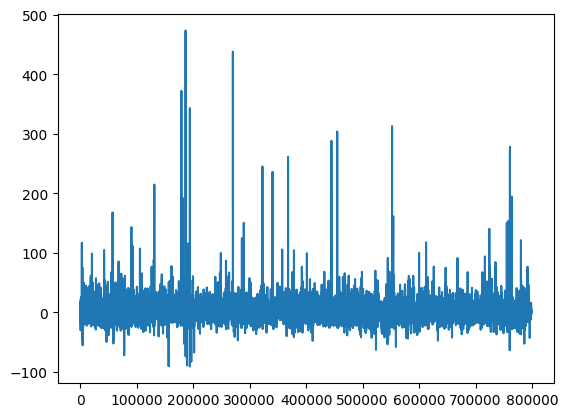

In [48]:
plt.plot( train_df['1W Tot Ret'].astype(float))

(-90.0, 100.0)

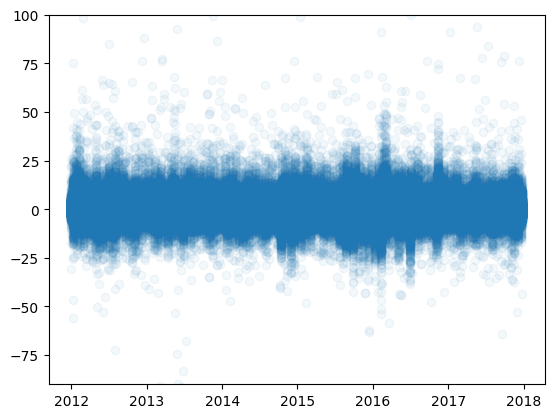

In [32]:
plt.scatter(train_df['Date'], train_df['1W Tot Ret'], alpha=0.05)
plt.ylim(-90,100)

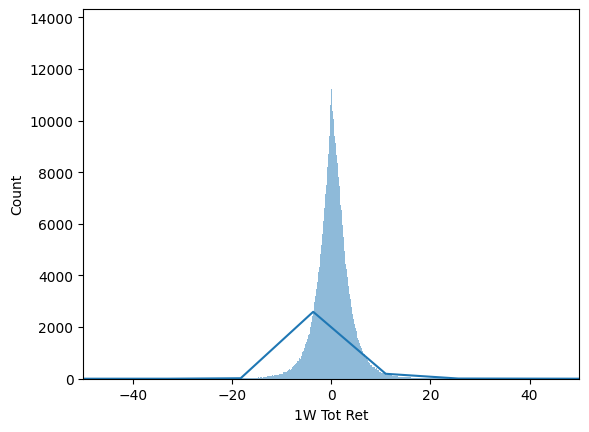

In [38]:
fig, ax = plt.subplots()
sns.histplot(train_df['Date'], x=train_df['1W Tot Ret'], kde=True, ax=ax)
ax.set_xlim(-50, 50)
plt.show()

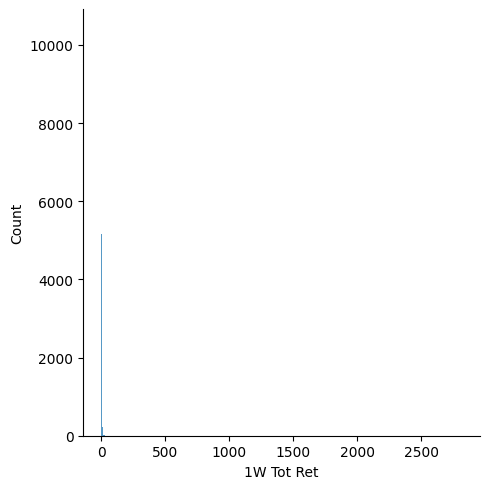

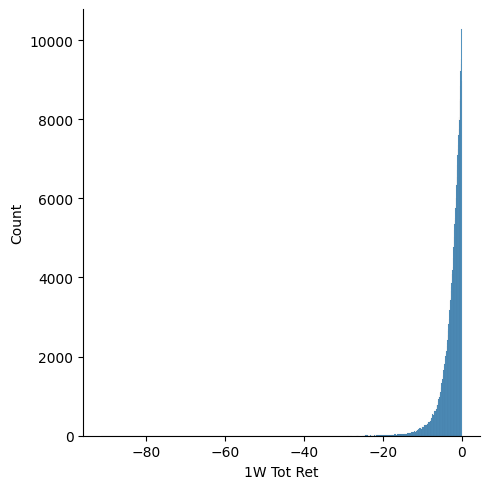

In [39]:
sns.displot(train_df['Date'], x=train_df[train_df['1W Tot Ret'] > 0]['1W Tot Ret'])
sns.displot(train_df['Date'], x=train_df[train_df['1W Tot Ret'] < 0]['1W Tot Ret'])

In [49]:
# Creating an index

data = train_df

dates = data['Date'].unique()

value_index = 100

collector = [[pd.to_datetime(data['Date'].unique()[0], format='%d-%m-%Y') - timedelta(weeks=1), 100]]

for d in dates[:]:
    period_df = data[data['Date'] == d].sort_values(by='1W Tot Ret')

    period_df['1W Tot Ret'] = period_df['1W Tot Ret'].astype(float)
    period_df['1W Volat'] = period_df['1W Volat'].astype(float)

    returns = period_df['1W Tot Ret'].mean()
    volat = period_df['1W Volat'].mean()
    within_std = period_df['1W Tot Ret'].std()

    p10 = np.percentile(period_df['1W Tot Ret'], q=10)
    p25 = np.percentile(period_df['1W Tot Ret'], q=25)
    median = period_df['1W Tot Ret'].median()
    p75 = np.percentile(period_df['1W Tot Ret'], q=75)
    p90 = np.percentile(period_df['1W Tot Ret'], q=90)

    neg = period_df[ period_df['1W Tot Ret'] < 0].count()[0]
    pos = period_df[ period_df['1W Tot Ret'] > 0].count()[0]

    mean_pos = period_df[ period_df['1W Tot Ret'] > 0]['1W Tot Ret'].mean()
    mean_neg = period_df[ period_df['1W Tot Ret'] < 0]['1W Tot Ret'].mean()

    all = period_df.count()[0]

    value_index = value_index * (1 + returns/100)

    collector.append([d, value_index, returns, volat, within_std, p10, p25, median, p75, p90, pos, neg, all, mean_pos, mean_neg])

Index_train = pd.DataFrame(collector, columns= ['Date', 'Index', 'Return', 'Avg. Volatility', 'Standard deviation', 'Percentile 10', 'Percentile 25', 'Median',  'Percentile 75', 'Percentile 90', 'Positives', 'Negatives', 'Number of tickers', 'Avg positives', 'Avg negatives'])

Index_train

,Date,Index,Return,Avg. Volatility,Standard deviation,Percentile 10,Percentile 25,Median,Percentile 75,Percentile 90,Positives,Negatives,Number of tickers,Avg positives,Avg negatives
0,2011-12-26,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,100.352140,0.352140,23.757295,2.723608,-2.34272,-1.077325,0.06040,1.554025,3.45615,1303.0,1237.0,2560.0,2.156111,-1.542388
2,2012-01-09,101.575414,1.218982,26.729377,5.598912,-3.58708,-1.286050,0.87190,3.569000,6.40834,1555.0,979.0,2559.0,3.873911,-2.966862
3,2012-01-16,103.412281,1.808377,25.100134,4.621382,-2.53080,-0.347400,1.32140,3.655800,6.90458,1787.0,751.0,2559.0,3.671544,-2.574451
4,2012-01-23,106.412902,2.901610,24.620568,4.680502,-1.49214,0.165850,2.33675,4.928575,8.22784,1971.0,574.0,2560.0,4.395416,-2.151991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2017-11-27,304.246551,0.266740,16.068449,2.719957,-1.99039,-0.719425,0.25605,1.162400,2.52948,1511.0,1059.0,2594.0,1.557455,-1.568832
310,2017-12-04,308.394857,1.363469,22.803248,4.405744,-3.15034,-0.656100,1.12220,3.414600,6.72350,1692.0,892.0,2597.0,3.529470,-2.725265
311,2017-12-11,309.846351,0.470661,18.763841,3.317100,-2.64106,-1.129800,0.29070,1.635700,3.62012,1475.0,1106.0,2603.0,2.205433,-1.833529
312,2017-12-18,312.884427,0.980511,20.678293,3.161943,-2.02366,-0.360475,0.94555,2.234250,4.13096,1795.0,785.0,2610.0,2.308393,-2.018385


In [50]:
Index_train.to_excel(f"{data_path}/Descriptive_statistic_Train.xlsx", index=False)

Sharpe-Ratio Index: 6.867998502367642
Std Index: 1.750355857767033


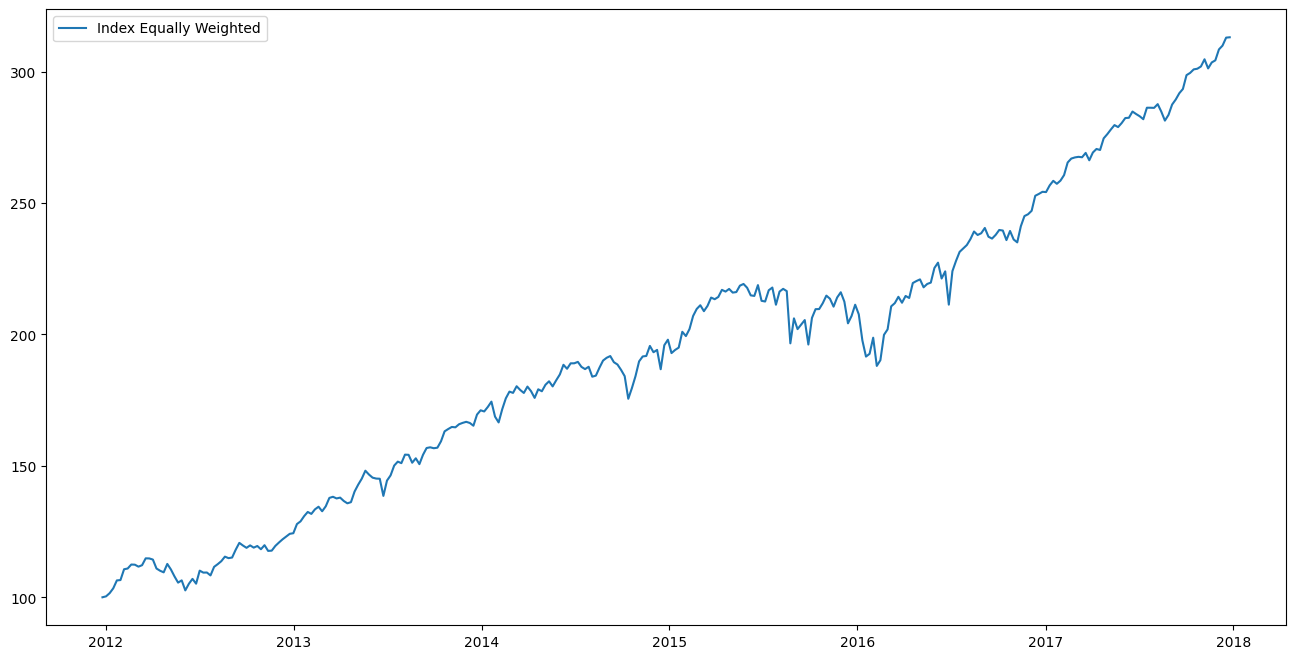

In [51]:
Index = Index_train

plt.figure(figsize=(16,8))
plt.plot(Index['Date'], Index[['Index']], label= 'Index Equally Weighted')
plt.legend()

sr_index = ((Index['Index'].iloc[-1] - 100) ) / Index['Return'].std()
std_index = Index['Return'].std()
print(f'Sharpe-Ratio Index: {sr_index / math.sqrt(len(Index))}')
print(f'Std Index: {std_index}')

(-30.0, 35.0)

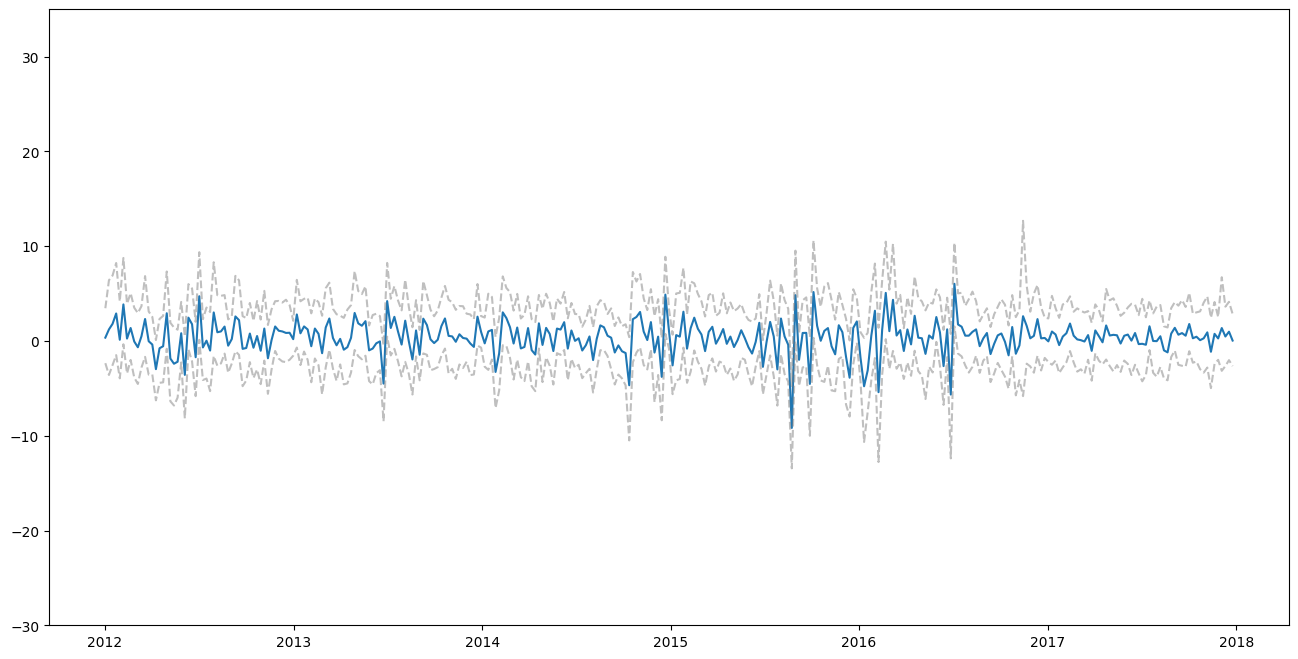

In [52]:
Index = Index_train

plt.figure(figsize=(16,8))
plt.plot(Index['Date'], Index[['Return']])
plt.plot(Index['Date'], Index[['Percentile 10']], color='grey', linestyle='dashed', alpha=0.5)
plt.plot(Index['Date'], Index[['Percentile 90']], color='grey', linestyle='dashed', alpha=0.5)
plt.ylim(-30,35)

Period 1 Std: Standard deviation    3.729965
dtype: float64


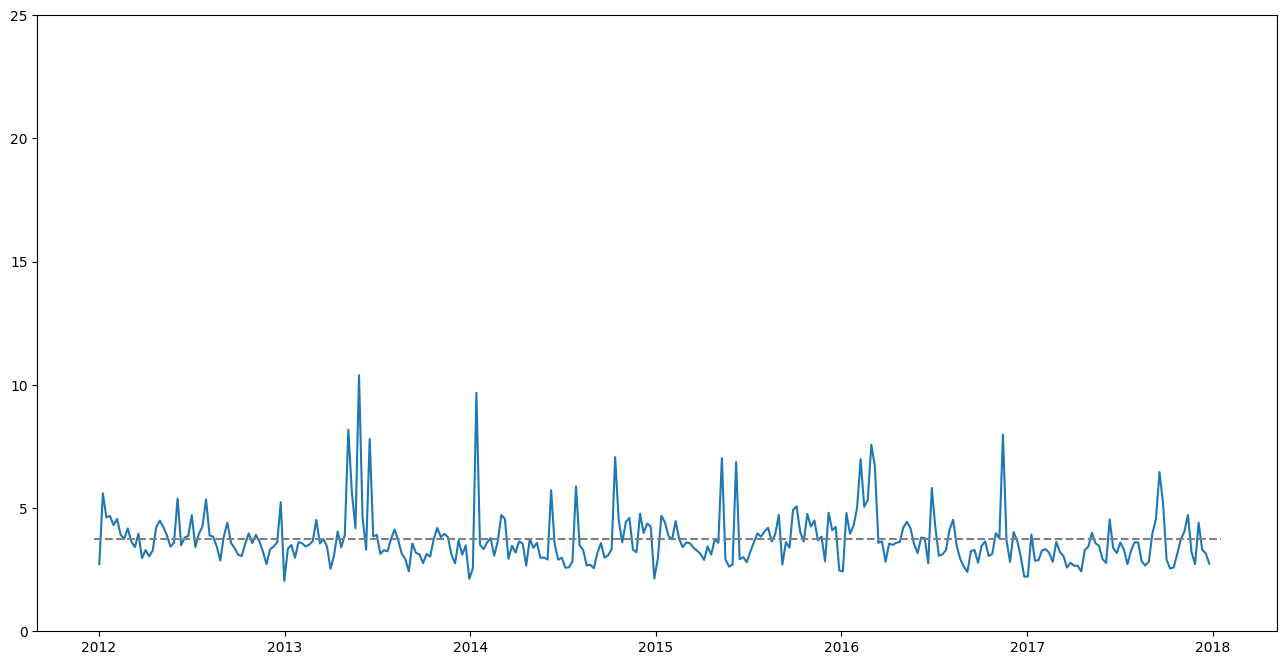

In [53]:
Index = Index_train

plt.figure(figsize=(16,8))
plt.plot(Index['Date'], Index[['Standard deviation']])

std_avg = Index[['Standard deviation']].mean()

plt.hlines(std_avg, xmin=15330, xmax=15330+7*len( Index) +20, color='grey', linestyles='dashed')

plt.ylim(0,25)

print(f'Period 1 Std: {std_avg}')

0.5505169334856909
0.4423104787078394


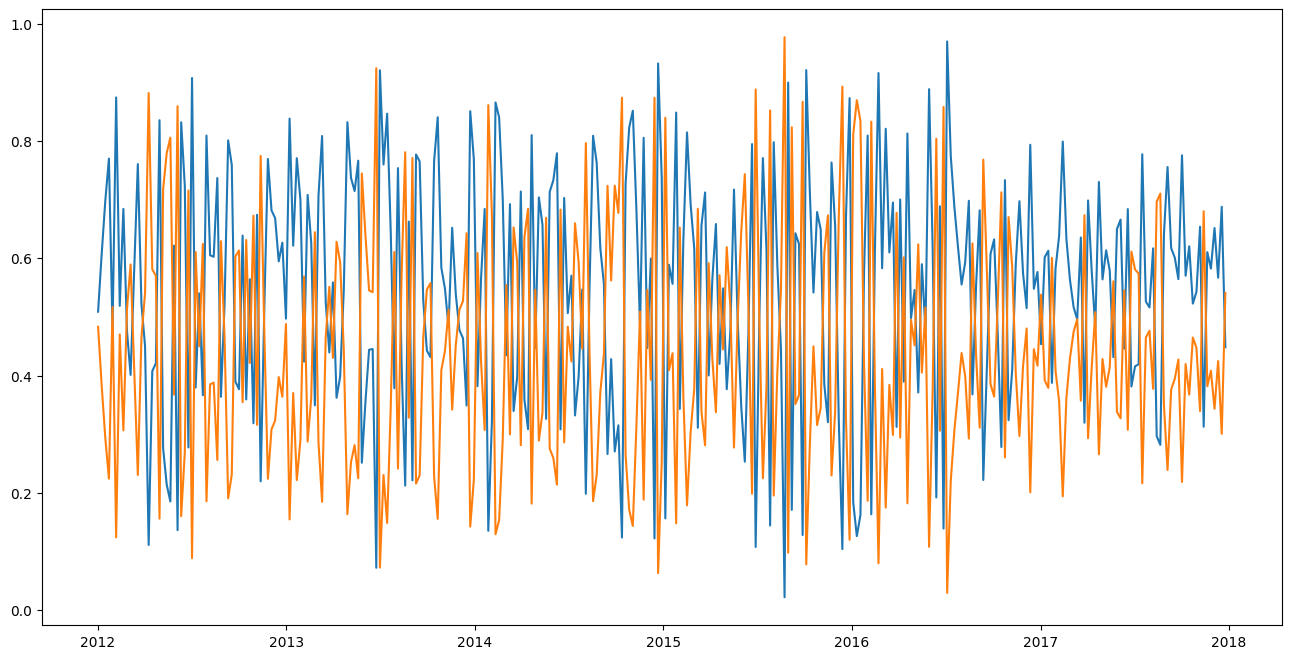

In [45]:
Index = Index_train

mean_p = (Index['Positives'] / Index['Number of tickers']).mean()
mean_n = (Index['Negatives'] / Index['Number of tickers']).mean()

plt.figure(figsize=(16,8))
plt.plot(Index['Date'],  Index['Positives'] / Index['Number of tickers'])
plt.plot(Index['Date'],  Index['Negatives'] / Index['Number of tickers'])

print(mean_p)
print(mean_n)

2.626280918995078
-2.363024338557516


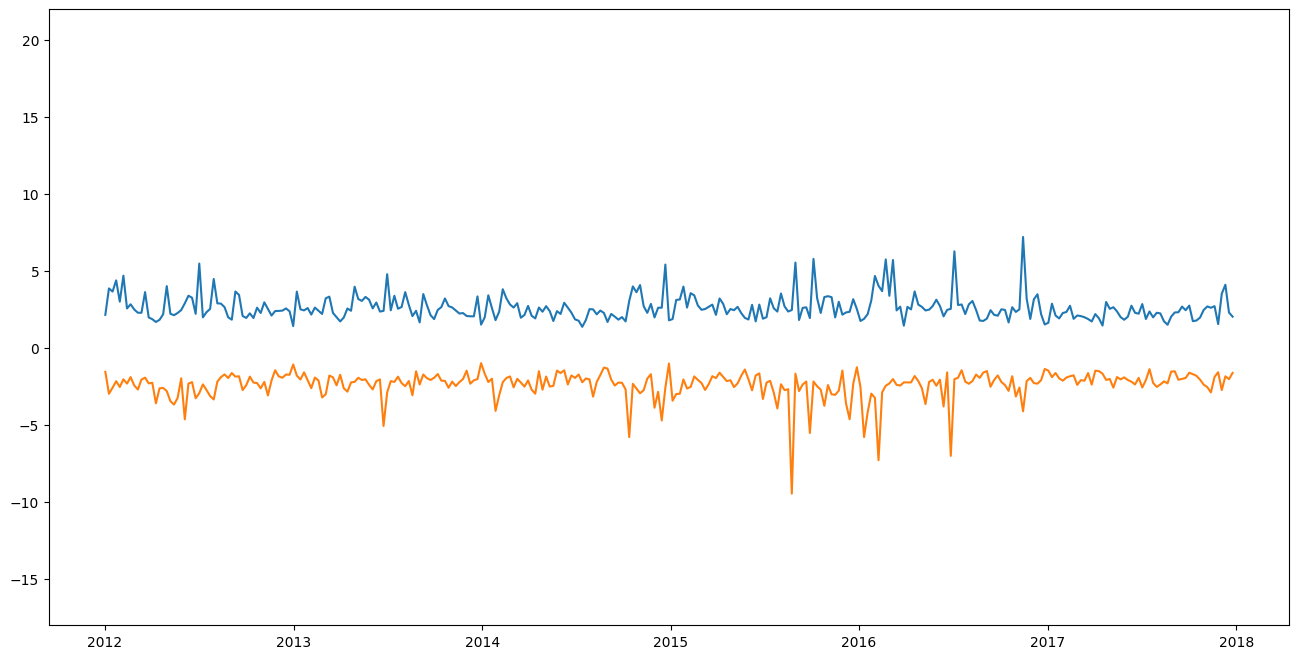

In [46]:
Index = Index_train

plt.figure(figsize=(16,8))
plt.plot(Index['Date'],  Index['Avg positives'])
plt.plot(Index['Date'],  Index['Avg negatives'])
plt.ylim(-18,22)

print(Index['Avg positives'].mean())
print(Index['Avg negatives'].mean())

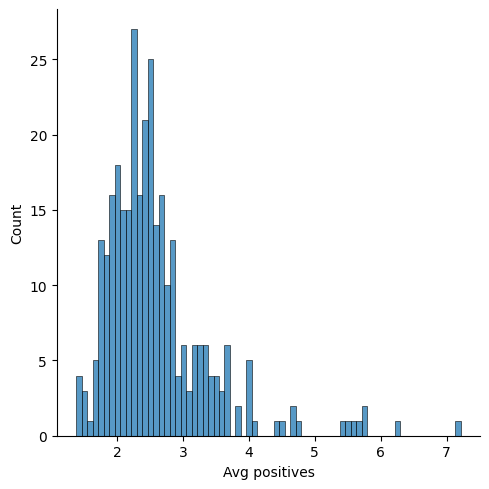

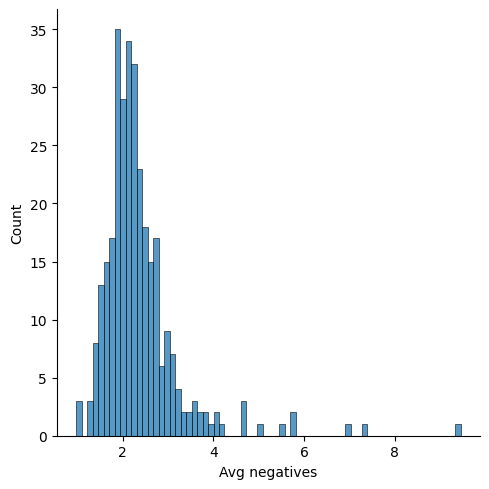

In [ ]:
Index = Index_train

sns.displot(Index['Date'], x=Index['Avg positives'], bins=70)
sns.displot(Index['Date'], x=-Index['Avg negatives'], bins=70)

#### SPX Data

In [16]:
SPX_df = pd.read_csv(f"{data_path}/SPX_raw.csv", low_memory=False)
SPX_df = SPX_df[ ~(SPX_df['1W Tot Ret']== ' ')]
SPX_df = SPX_df[ ~(SPX_df['1W Volat']== ' ')]
SPX_df['Date'] = pd.to_datetime(SPX_df['Date'], format='%Y-%m-%d')
SPX_df = SPX_df.sort_values(by='Date').reset_index(drop=True)
SPX_df = SPX_df[ SPX_df['Date'] >= pd.to_datetime('01-01-2018', format='%d-%m-%Y')]
SPX_df['1W Tot Ret'] = SPX_df['1W Tot Ret'].astype(float)

<ipython-input-16-b5cd4403879a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPX_df['1W Tot Ret'] = SPX_df['1W Tot Ret'].astype(float)


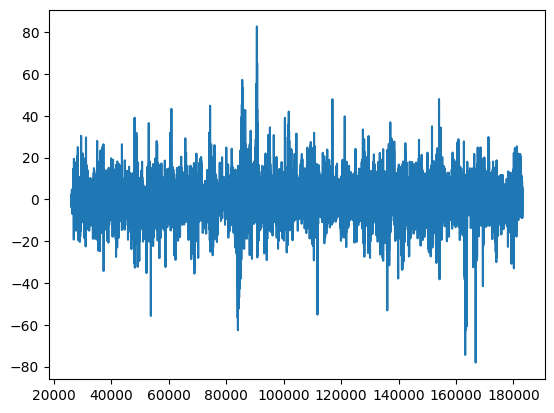

In [17]:
plt.plot( SPX_df['1W Tot Ret'])

(-90.0, 100.0)

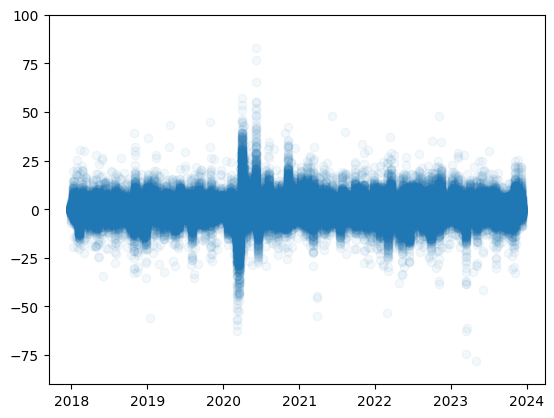

In [18]:
plt.scatter(SPX_df['Date'], SPX_df['1W Tot Ret'], alpha=0.05)
plt.ylim(-90,100)

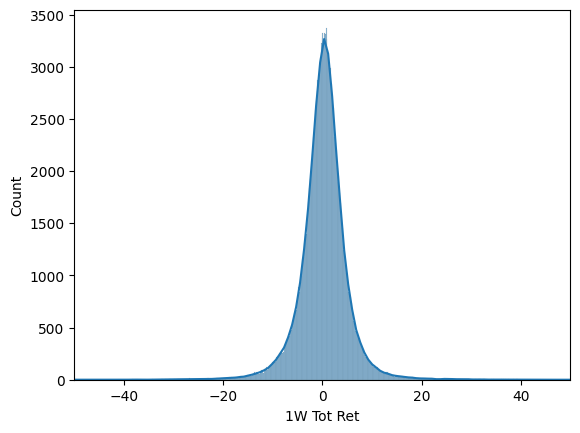

In [19]:
fig, ax = plt.subplots()
sns.histplot(SPX_df['Date'], x=SPX_df['1W Tot Ret'], kde=True, ax=ax)
ax.set_xlim(-50, 50)
plt.show()

In [20]:
# Creating an index

data = SPX_df

dates = data['Date'].unique()

value_index = 100

collector = [[pd.to_datetime(data['Date'].unique()[0], format='%d-%m-%Y') - timedelta(weeks=1), 100, 0, 30, 4, 0]]

for d in dates[:]:
    period_df = data[data['Date'] == d].sort_values(by='1W Tot Ret')

    period_df['1W Tot Ret'] = period_df['1W Tot Ret'].astype(float)
    period_df['1W Volat'] = period_df['1W Volat'].astype(float)

    returns = period_df['1W Tot Ret'].mean()
    volat = period_df['1W Volat'].mean()
    within_std = period_df['1W Tot Ret'].std()

    p10 = np.percentile(period_df['1W Tot Ret'], q=10)
    p25 = np.percentile(period_df['1W Tot Ret'], q=25)
    median = period_df['1W Tot Ret'].median()
    p75 = np.percentile(period_df['1W Tot Ret'], q=75)
    p90 = np.percentile(period_df['1W Tot Ret'], q=90)

    neg = period_df[ period_df['1W Tot Ret'] < 0].count()[0]
    pos = period_df[ period_df['1W Tot Ret'] > 0].count()[0]

    mean_pos = period_df[ period_df['1W Tot Ret'] > 0]['1W Tot Ret'].mean()
    mean_neg = period_df[ period_df['1W Tot Ret'] < 0]['1W Tot Ret'].mean()

    all = period_df.count()[0]

    value_index = value_index * (1 + returns/100)

    collector.append([d, value_index, returns, volat, within_std, p10, p25, median, p75, p90, pos, neg, all, mean_pos, mean_neg])

Index_spx = pd.DataFrame(collector, columns= ['Date', 'Index', 'Return', 'Avg. Volatility', 'Standard deviation', 'Percentile 10', 'Percentile 25', 'Median',  'Percentile 75', 'Percentile 90', 'Positives', 'Negatives', 'Number of tickers', 'Avg positives', 'Avg negatives'])

Index_spx

,Date,Index,Return,Avg. Volatility,Standard deviation,Percentile 10,Percentile 25,Median,Percentile 75,Percentile 90,Positives,Negatives,Number of tickers,Avg positives,Avg negatives
0,2017-12-25,100.000000,0.000000,30.000000,4.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,99.894742,-0.105258,11.377279,1.320677,-1.48899,-0.916075,-0.0723,0.607875,1.32138,241.0,261.0,504.0,0.898906,-1.033281
2,2018-01-08,102.434202,2.542135,18.740256,3.464032,-1.80896,0.545400,2.4835,4.368800,6.59676,407.0,98.0,505.0,3.658940,-2.096022
3,2018-01-15,103.739142,1.273930,18.897868,3.503471,-3.55288,-0.517000,1.4058,3.207500,5.25648,354.0,151.0,505.0,2.964171,-2.688621
4,2018-01-22,105.034938,1.249091,20.567804,2.955320,-1.76686,-0.267400,1.2579,2.870300,4.56424,364.0,140.0,505.0,2.506079,-2.010156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,2023-11-13,169.543082,-0.239551,22.714718,3.590766,-4.37364,-2.280200,-0.1388,1.851600,3.77358,243.0,259.0,503.0,2.547898,-2.855728
308,2023-11-20,176.502373,4.104733,28.510417,3.916951,-0.21892,1.853850,3.6036,6.034400,8.85342,449.0,54.0,503.0,4.798889,-1.667046
309,2023-11-27,177.579706,0.610379,13.742500,1.673339,-1.26900,-0.316700,0.6298,1.543800,2.36936,344.0,157.0,503.0,1.409365,-1.132490
310,2023-12-04,182.550592,2.799242,21.074935,4.069578,-1.32152,0.468050,2.2818,4.259300,7.55178,397.0,105.0,503.0,4.042475,-1.874701


In [22]:
Index_spx.to_excel(f"{data_path}/Descriptive_statistic_SPX.xlsx", index=False)

Sharpe-Ratio Index: 1.5588039937968166
Std Index: 2.9967211482969476


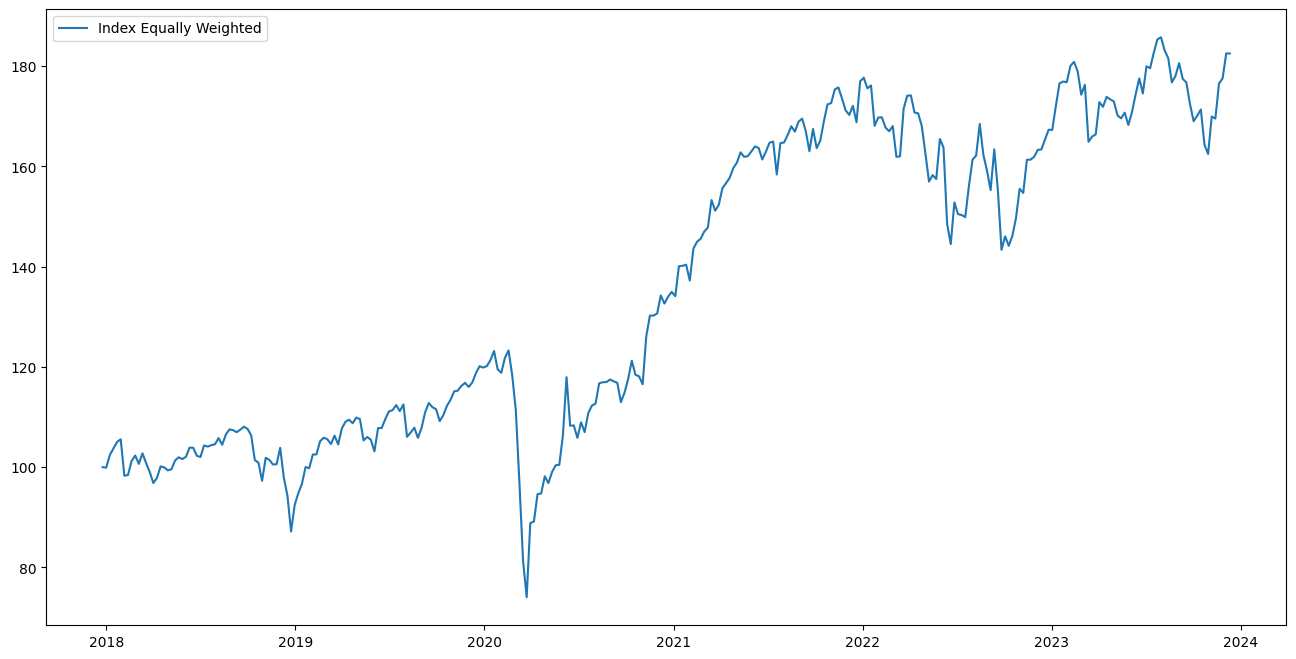

In [21]:
Index = Index_spx

plt.figure(figsize=(16,8))
plt.plot(Index['Date'], Index[['Index']], label= 'Index Equally Weighted')
plt.legend()

sr_index = ((Index['Index'].iloc[-1] - 100) ) / Index['Return'].std()
std_index = Index['Return'].std()
print(f'Sharpe-Ratio Index: {sr_index / math.sqrt(len(Index))}')
print(f'Std Index: {std_index}')

(-30.0, 35.0)

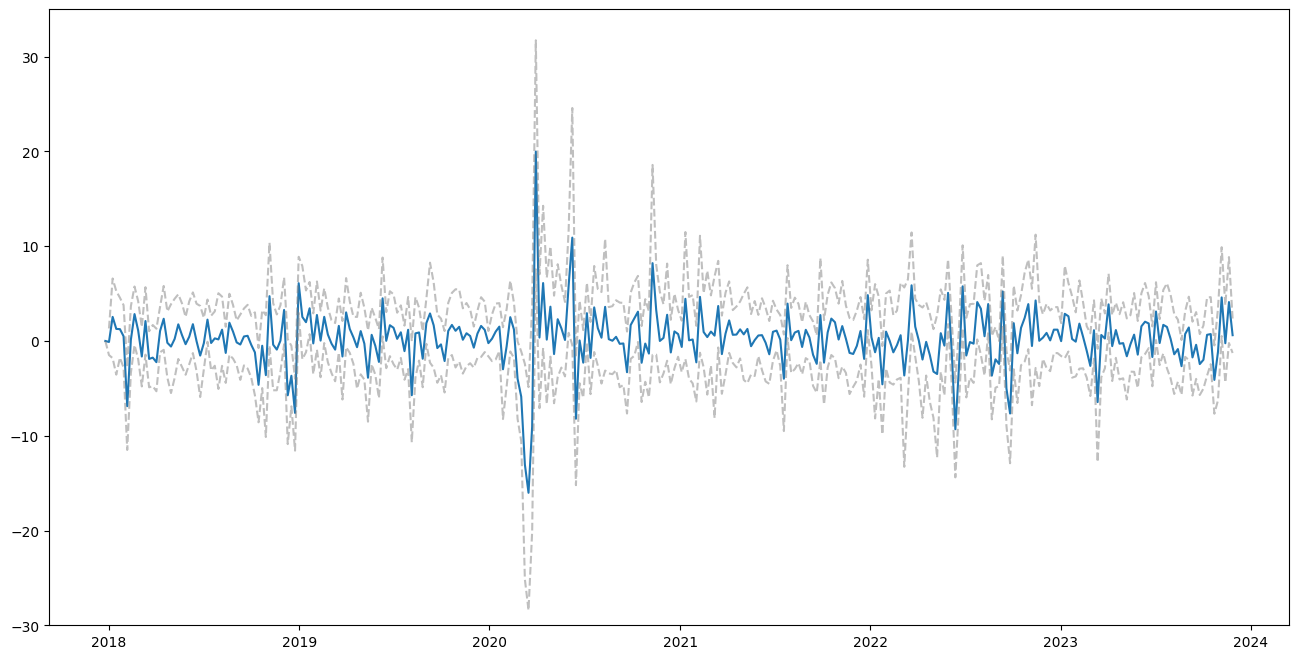

In [ ]:
Index = Index_spx

plt.figure(figsize=(16,8))
plt.plot(Index['Date'], Index[['Return']])
plt.plot(Index['Date'], Index[['Percentile 10']], color='grey', linestyle='dashed', alpha=0.5)
plt.plot(Index['Date'], Index[['Percentile 90']], color='grey', linestyle='dashed', alpha=0.5)
plt.ylim(-30,35)

Period 1 Std: Standard deviation    3.215078
dtype: float64
Period 1 Std: Standard deviation    3.869931
dtype: float64


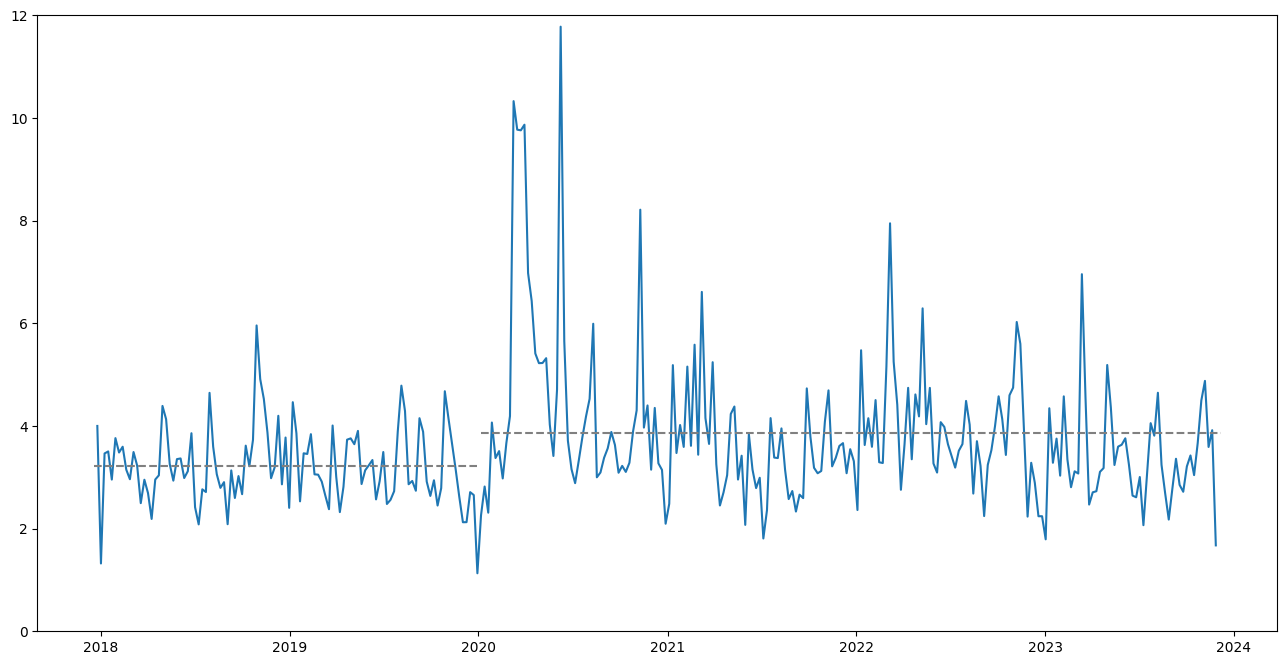

In [ ]:
Index = Index_spx

plt.figure(figsize=(16,8))
plt.plot(Index['Date'], Index[['Standard deviation']])

std_avg1 = Index[Index['Date']< pd.to_datetime('01-01-2020', format='%d-%m-%Y')][['Standard deviation']].mean()
std_avg2 = Index[Index['Date']> pd.to_datetime('01-01-2020', format='%d-%m-%Y')][['Standard deviation']].mean()

plt.hlines(std_avg1, xmin=17518, xmax=17518+7*len( Index[Index['Date']< pd.to_datetime('01-01-2020', format='%d-%m-%Y')]), color='grey', linestyles='dashed')
plt.hlines(std_avg2, xmin=17518+5+7*len( Index[Index['Date']< pd.to_datetime('01-01-2020', format='%d-%m-%Y')])+2, xmax=17518+10+7*len( Index[Index['Date']< pd.to_datetime('01-01-2020', format='%d-%m-%Y')])+7*len( Index[Index['Date'] > pd.to_datetime('01-01-2020', format='%d-%m-%Y')]), color='grey', linestyles='dashed')

plt.ylim(0,12)

print(f'Period 1 Std: {std_avg1}')
print(f'Period 1 Std: {std_avg2}')

0.540410684633764
0.4578893800306984


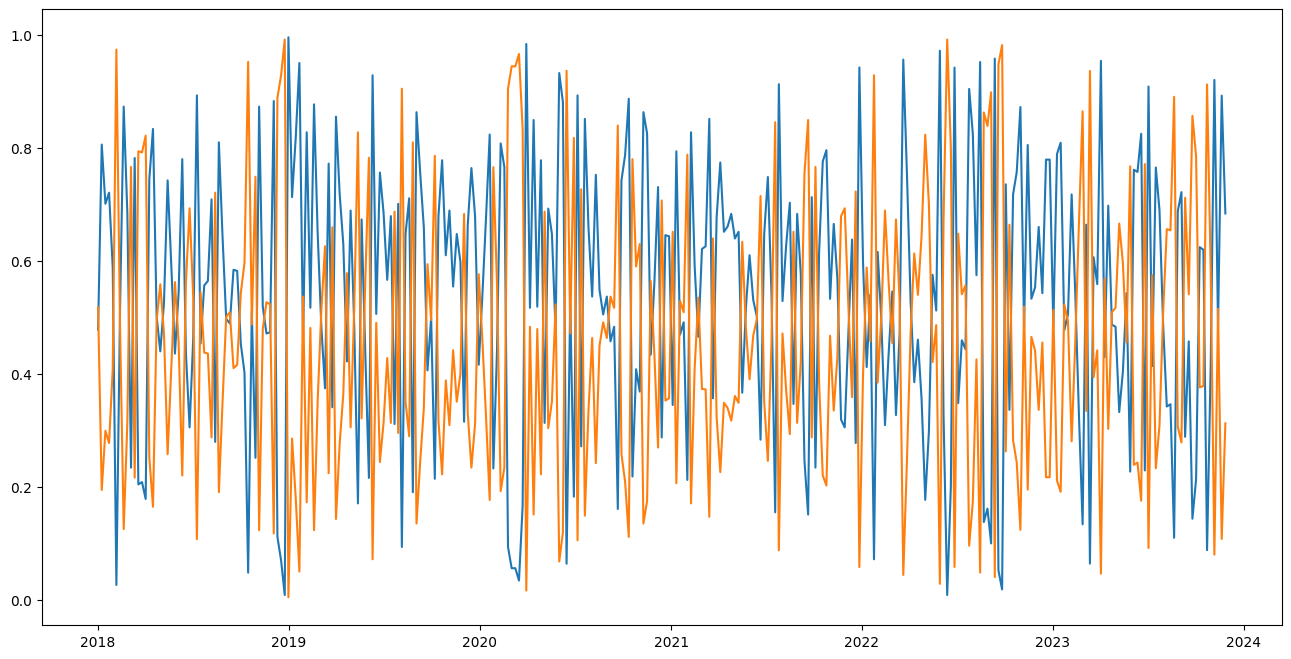

In [ ]:
Index = Index_spx

mean_p = (Index['Positives'] / Index['Number of tickers']).mean()
mean_n = (Index['Negatives'] / Index['Number of tickers']).mean()

plt.figure(figsize=(16,8))
plt.plot(Index['Date'],  Index['Positives'] / Index['Number of tickers'])
plt.plot(Index['Date'],  Index['Negatives'] / Index['Number of tickers'])

print(mean_p)
print(mean_n)

2.918900766381147
-2.847520248293208


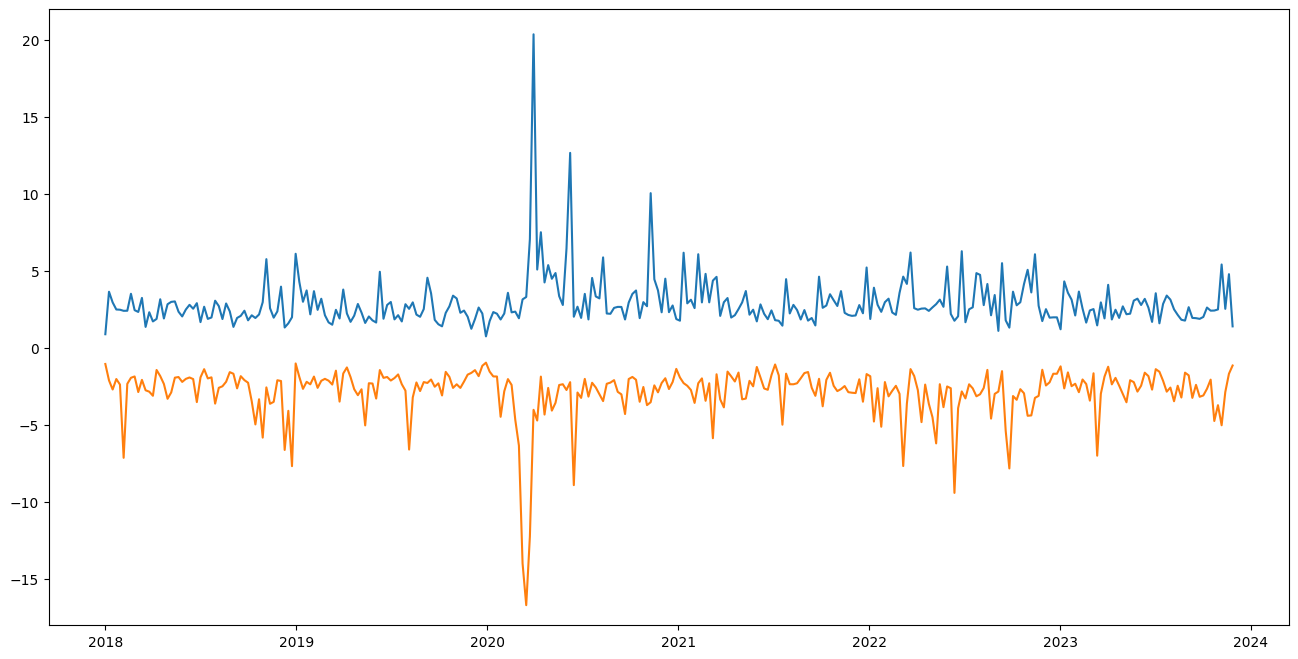

In [ ]:
Index = Index_spx

plt.figure(figsize=(16,8))
plt.plot(Index['Date'],  Index['Avg positives'])
plt.plot(Index['Date'],  Index['Avg negatives'])
plt.ylim(-18,22)

print(Index['Avg positives'].mean())
print(Index['Avg negatives'].mean())

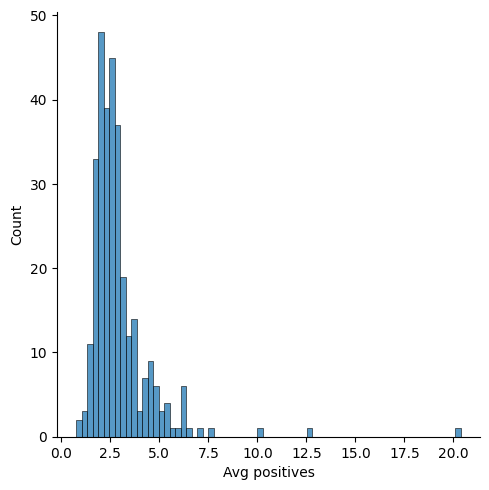

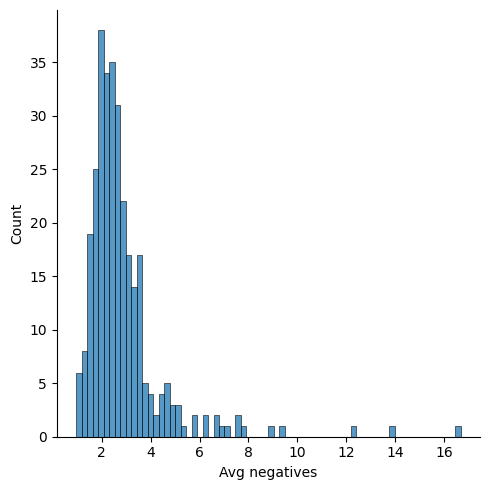

In [ ]:
Index = Index_spx

sns.displot(Index['Date'], x=Index['Avg positives'], bins= 70)
sns.displot(Index['Date'], x=-Index['Avg negatives'], bins= 70)